In [11]:
import polars as pl
import pint
from great_tables import GT, html
import plotnine as pn
med_gran = pl.read_parquet("./data/emissions_medium_granularity.parquet")
ureg = pint.UnitRegistry()
ureg.define("Million_bbl = 1e6*bbl = Mbbl")
pn.theme_set(pn.theme_bw())

Loaded up polars and the parquet file containing med-granularity production & emissions data from Carbon Majors (https://carbonmajors.org/Downloads). Let's take a peek at the data, first in terms of counts of rows from different parent types, commodities, and units.

In [2]:
med_gran.describe()
slim_counts = med_gran.select(
    pl.struct(['parent_type', 'commodity', 'production_unit']).value_counts(sort=True)
    ).unnest('parent_type').unnest('parent_type')
print(slim_counts)

shape: (23, 4)
┌────────────────────────┬────────────────────┬────────────────────┬───────┐
│ parent_type            ┆ commodity          ┆ production_unit    ┆ count │
│ ---                    ┆ ---                ┆ ---                ┆ ---   │
│ str                    ┆ str                ┆ str                ┆ u32   │
╞════════════════════════╪════════════════════╪════════════════════╪═══════╡
│ Investor-owned Company ┆ Oil & NGL          ┆ Million bbl/yr     ┆ 1945  │
│ Investor-owned Company ┆ Natural Gas        ┆ Bcf/yr             ┆ 1802  │
│ State-owned Entity     ┆ Oil & NGL          ┆ Million bbl/yr     ┆ 1745  │
│ State-owned Entity     ┆ Natural Gas        ┆ Bcf/yr             ┆ 1617  │
│ Investor-owned Company ┆ Bituminous Coal    ┆ Million tonnes/yr  ┆ 677   │
│ …                      ┆ …                  ┆ …                  ┆ …     │
│ State-owned Entity     ┆ Metallurgical Coal ┆ Million tonnes/yr  ┆ 126   │
│ Nation State           ┆ Cement             ┆ Million Tonne

Polars works pretty nicely with holoviz to compare counts across the groups we defined above.

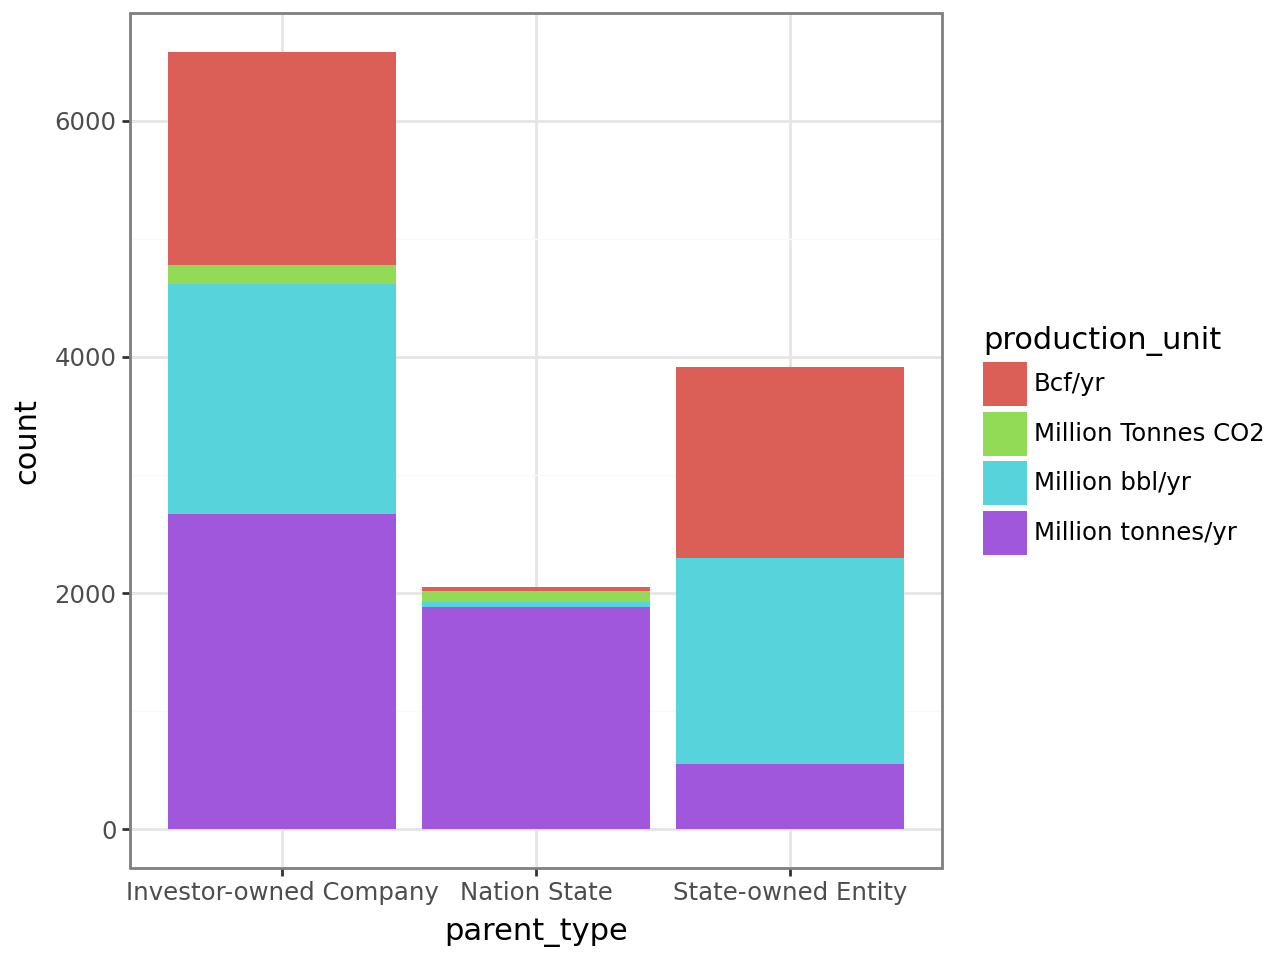

In [12]:
(
    pn.ggplot(slim_counts, pn.aes(x="parent_type", y="count", fill="production_unit"))
    + pn.geom_col()
)

Let's instead aggregate the production records, and keep the different units that Carbon Majors reports in. If they didn't want to attempt unit conversion, I won't either for purposes of this example. In particular, their methodology for calculating cement production (worth reading more into [here](https://carbonmajors.org/site//data/000/000/Carbon_Majors_README.pdf#%5B%7B%22num%22%3A7%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C70%2C744%2C0%5D)) in terms of CO2 emissions complicates conversion.

In [15]:
units_mapper = {
    "Million tonnes/yr": "MTS",
    "Million Tonnes CO2": "MTCO",
    "Million bbl/yr": "Mbbl",
    "Bcf/yr": "Bcf"
}

parent_enum = pl.Enum(
    ['Nation State', 'State-owned Entity', 'Investor-owned Company']
)

med_gran_agg = med_gran.group_by(['parent_type', 'commodity', 'production_unit']).agg(
    pl.col("production_value").sum().alias("sum_prod_val"),
    pl.col("total_emissions_MtCO2e").sum().alias("sum_mtco2e")
    ).with_columns(
        pl.col("production_unit").replace(units_mapper)
    ).sort(
        pl.col("production_unit", "commodity")
    ).with_columns(
        pl.col("parent_type").cast(parent_enum)
    )

(
    GT(med_gran_agg, rowname_col="commodity", groupname_col="parent_type")
    .tab_header("Total Carbon Majors production & emissions")
    .tab_stubhead("")
    .fmt_integer(['sum_prod_val', 'sum_mtco2e'])
    .cols_label(
        sum_prod_val="Produced / yr",
        sum_mtco2e=html("Emitted<br>(MtCO2e) / yr"),
        production_unit = "Units"
    )
)

GT(_tbl_data=shape: (23, 5)
┌────────────────────────┬─────────────────────┬─────────────────┬───────────────┬───────────────┐
│ parent_type            ┆ commodity           ┆ production_unit ┆ sum_prod_val  ┆ sum_mtco2e    │
│ ---                    ┆ ---                 ┆ ---             ┆ ---           ┆ ---           │
│ enum                   ┆ str                 ┆ str             ┆ f64           ┆ f64           │
╞════════════════════════╪═════════════════════╪═════════════════╪═══════════════╪═══════════════╡
│ Nation State           ┆ Natural Gas         ┆ Bcf             ┆ 335678.0995   ┆ 24467.707708  │
│ State-owned Entity     ┆ Natural Gas         ┆ Bcf             ┆ 1.7781e6      ┆ 129606.058869 │
│ Investor-owned Company ┆ Natural Gas         ┆ Bcf             ┆ 1.4416e6      ┆ 105081.248276 │
│ Nation State           ┆ Cement              ┆ MTCO            ┆ 46322.53495   ┆ 23161.267475  │
│ Investor-owned Company ┆ Cement              ┆ MTCO            ┆ 10315.5015    ┆ 6520.71313    │
│ …                      ┆ …                   ┆ …               ┆ …             ┆ …             │
│ Investor-owned Company ┆ Sub-Bituminous Coal ┆ MTS             ┆ 8106.340362   ┆ 16367.434358  │
│ Investor-owned Company ┆ Thermal Coal        ┆ MTS             ┆ 19301.525783  ┆ 45733.579536  │
│ State-owned Entity     ┆ Oil & NGL           ┆ Mbbl            ┆ 709077.475518 ┆ 282764.424409 │
│ Investor-owned Company ┆ Oil & NGL           ┆ Mbbl            ┆ 519850.938205 ┆ 207305.063826 │
│ Nation State           ┆ Oil & NGL           ┆ Mbbl            ┆ 95475.24      ┆ 38073.415411  │
└────────────────────────┴─────────────────────┴─────────────────┴───────────────┴───────────────┘, _body=<great_tables._gt_data.Body object at 0x0000020BD991BC80>, _boxhead=Boxhead([ColInfo(var='parent_type', type=<ColInfoTypeEnum.row_group: 3>, column_label='parent_type', column_align='center', column_width=None), ColInfo(var='commodity', type=<ColInfoTypeEnum.stub: 2>, column_label='commodity', column_align='left', column_width=None), ColInfo(var='production_unit', type=<ColInfoTypeEnum.default: 1>, column_label='Units', column_align='left', column_width=None), ColInfo(var='sum_prod_val', type=<ColInfoTypeEnum.default: 1>, column_label='Produced / yr', column_align='right', column_width=None), ColInfo(var='sum_mtco2e', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Emitted<br>(MtCO2e) / yr', type='html'), column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id='Nation State', rowname='Natural Gas', group_label=None, built=False), RowInfo(rownum_i=1, group_id='State-owned Entity', rowname='Natural Gas', group_label=None, built=False), RowInfo(rownum_i=2, group_id='Investor-owned Company', rowname='Natural Gas', group_label=None, built=False), RowInfo(rownum_i=3, group_id='Nation State', rowname='Cement', group_label=None, built=False), RowInfo(rownum_i=4, group_id='Investor-owned Company', rowname='Cement', group_label=None, built=False), RowInfo(rownum_i=5, group_id='Nation State', rowname='Anthracite Coal', group_label=None, built=False), RowInfo(rownum_i=6, group_id='Investor-owned Company', rowname='Anthracite Coal', group_label=None, built=False), RowInfo(rownum_i=7, group_id='Investor-owned Company', rowname='Bituminous Coal', group_label=None, built=False), RowInfo(rownum_i=8, group_id='Nation State', rowname='Bituminous Coal', group_label=None, built=False), RowInfo(rownum_i=9, group_id='State-owned Entity', rowname='Bituminous Coal', group_label=None, built=False), RowInfo(rownum_i=10, group_id='Investor-owned Company', rowname='Lignite Coal', group_label=None, built=False), RowInfo(rownum_i=11, group_id='State-owned Entity', rowname='Lignite Coal', group_label=None, built=False), RowInfo(rownum_i=12, group_id='Nation State', rowname='Lignite Coal', group_label=None, built=False), RowInfo(rownum_i=13, group_id='State-owned Entity', rowname='Metallurgical Coal', group_label=None, built=False), Ro

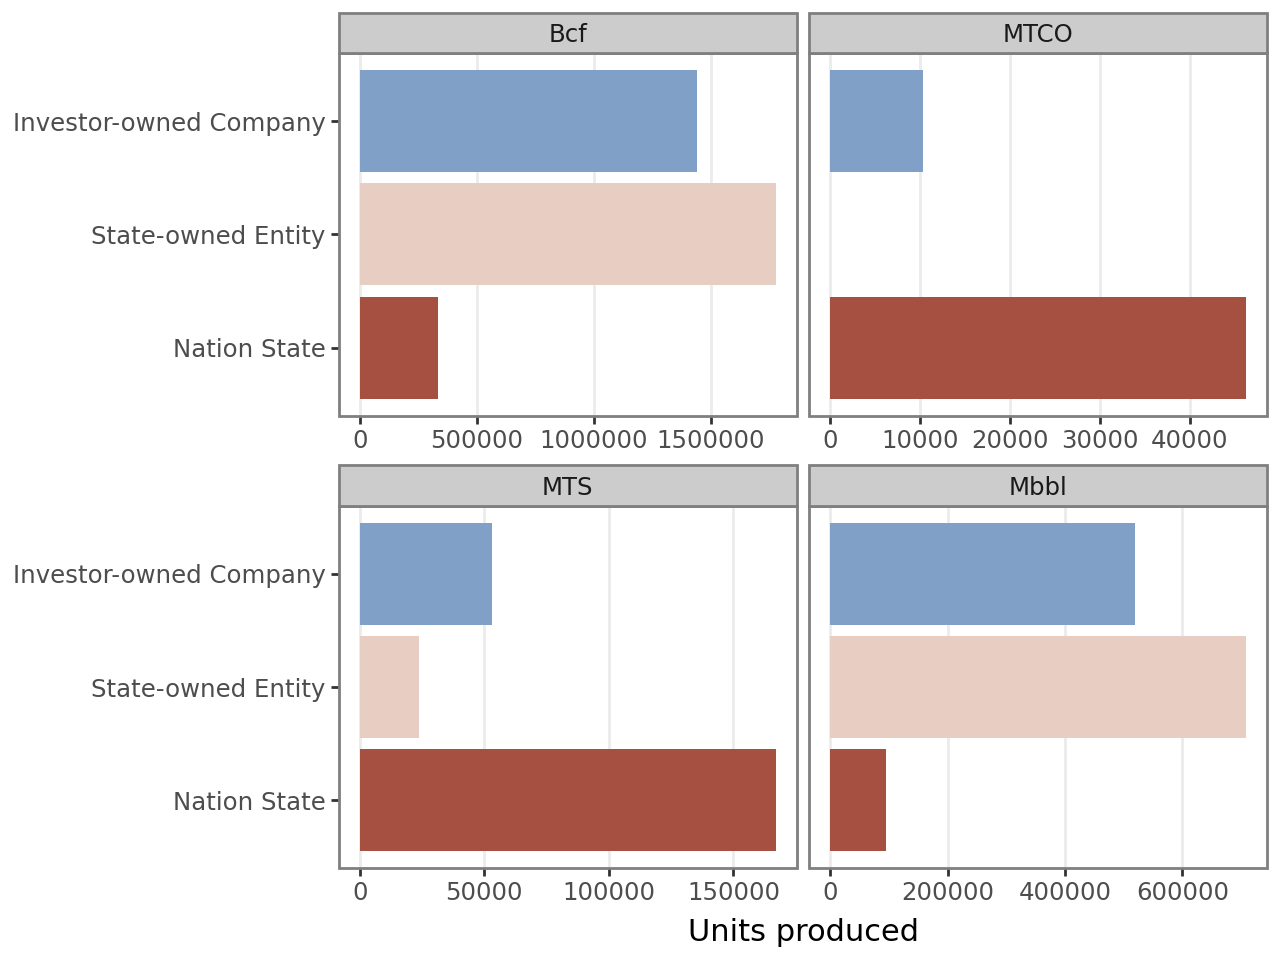

In [38]:
parent_cmap = {
    'Nation State': '#A65041',
    'State-owned Entity': '#E7CDC2',
    'Investor-owned Company': '#80A0C7'
}

med_gran_viz = med_gran_agg.group_by(['parent_type', 'production_unit']).agg(pl.col("sum_prod_val").sum())

(
    pn.ggplot(med_gran_viz, pn.aes(x="parent_type", y="sum_prod_val", fill="parent_type"))
    + pn.facet_wrap("production_unit",scales="free_x")
    + pn.geom_col()
    + pn.coord_flip()
    + pn.scale_x_discrete(name="")
    + pn.scale_y_continuous(name="Units produced")
    + pn.scale_fill_manual(values = parent_cmap)
    + pn.guides(fill = "none")
    + pn.theme(panel_grid = pn.element_blank(),
        panel_grid_major_x = pn.element_line(color="#EBEBEB"))
)